We will fit a simple continuous (linear) mixture of a log-normal and a power law distributions:
$$
p(x \mid \alpha, x_{\text{min}}, \mu , \sigma, \delta) = \delta \left[ \frac{\sqrt{4}}{\text{erfc}\left( \frac{x_{\text{min}}-\mu}{\sqrt{2}\sigma}\right)}\frac{1}{x\sigma\sqrt{2\pi}}\exp\left(-\frac{(\ln x -\mu)^2}{2\sigma^2}\right) \right] + (1-\delta) \left[ \frac{\alpha-1}{x_{\text{min}}^{1-\alpha}} x^{-\alpha} \right].
$$

In [1]:
source("../power_law_aux.r")
library(poweRlaw)
library(rstan)
rstan_options(auto_write = TRUE)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.9, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Here's the stan code :

In [2]:
writeLines(readLines("../stan/continuous_plaw_lognormal_mixture_fixedDelta.stan"))

functions{
  real truncated_lognormal_lpdf(real x, real mu, real sigma, real x_min){
       real lconst = log(2) - log(erfc( (log(x_min)-mu)/(sqrt(2)*sigma) )) ; 
       real ldens = lognormal_lpdf(x | mu, sigma) ; 
       return(ldens + lconst);
  }
  real power_law_lpdf(real x, real a, real m){
     return ( log(a-1)-log(m) -a *( log(x) - log(m)) );
    }
  real pl_ln_mix_lpdf(real x, real alpha, real x_min, real mu, real sigma, real delta){
    real l1 = truncated_lognormal_lpdf(x | mu, sigma, x_min);
    real l2 = power_law_lpdf(x | alpha, x_min);
    real ans = log_mix(delta, l1, l2);
    return(ans);
  }
}
data{
  int<lower=0> K; // number of unique values  
  real values[K];
  int<lower=0> frequencies[K]; 
  real<lower=0> x_min;
  real<lower=0> alpha_shape;
  real<lower=0> alpha_rate;
  real<lower=0> adelta;
  real<lower=0> bdelta;
}
parameters{
  real<lower=1, upper=8> alpha;
  real<lower=0,upper=1> delta;
  real mu;
  real<lower=0> sigma;
}
model{
  /*WARNING: I know this dist

Let's load the compiled model and prepare the data

In [3]:
contplaw.mix <- readRDS("../stan/continuous_plaw_lognormal_mixture_fixedDelta.rds")

In [4]:
data("moby")
the.data <- moby
cdata <- compress_data(the.data)
pl.data <- list(
  K = cdata$K,
  values = cdata$v,
  frequencies = cdata$fs,
  x_min = 1,
  alpha_shape = 1,
  alpha_rate = 1,
  adelta = 1,
  bdelta = 1
)

In [5]:
posterior.contmix <- sampling(contplaw.mix, data = pl.data, control = list(adapt_delta = .95), chains = 1)


SAMPLING FOR MODEL 'continuous_plaw_lognormal_mixture_fixedDelta' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000194 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.94 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 4.45504 seconds (Warm-up)
Chain 1:                2.39887 seconds 

In [6]:
posterior.contmix

Inference for Stan model: continuous_plaw_lognormal_mixture_fixedDelta.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

           mean se_mean   sd      2.5%       25%       50%       75%     97.5%
alpha      8.00    0.00 0.00      8.00      8.00      8.00      8.00      8.00
delta      0.52    0.00 0.00      0.51      0.52      0.52      0.52      0.53
mu         0.57    0.00 0.06      0.44      0.54      0.58      0.62      0.69
sigma      1.69    0.00 0.03      1.63      1.67      1.69      1.71      1.75
lp__  -23504.26    0.07 1.45 -23508.12 -23504.93 -23503.93 -23503.22 -23502.50
      n_eff Rhat
alpha   703    1
delta   717    1
mu      466    1
sigma   466    1
lp__    438    1

Samples were drawn using NUTS(diag_e) at Tue Mar 19 14:11:00 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

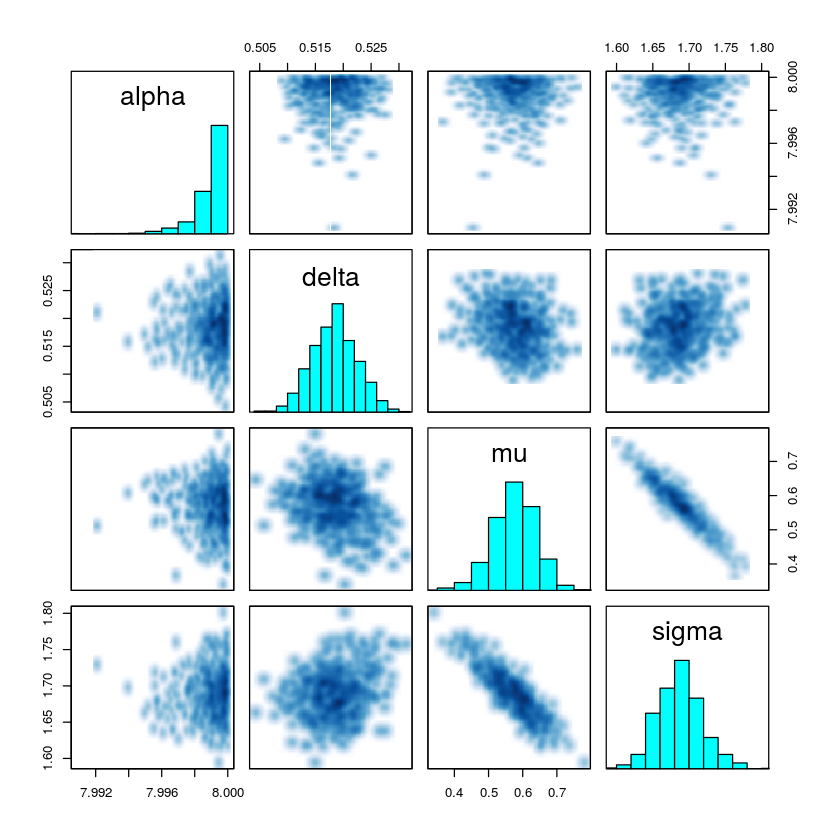

In [7]:
pairs(posterior.contmix, pars = c("alpha", "delta", "mu", "sigma"))

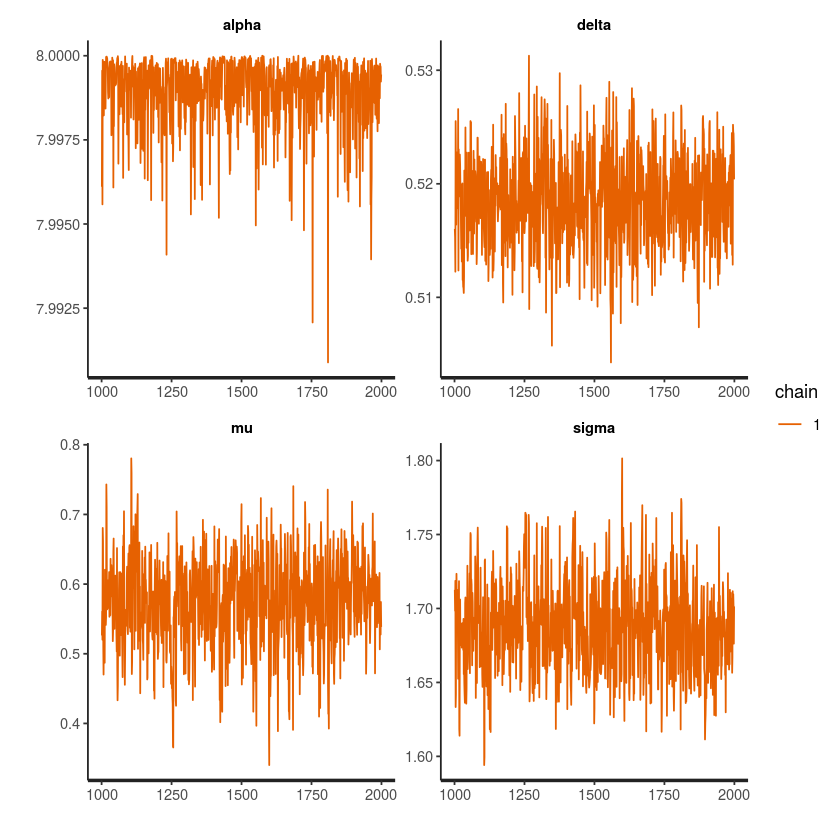

In [8]:
stan_trace(posterior.contmix, pars = c("alpha", "delta", "mu", "sigma"))

Now let's annotate the results and compare with maximum likelihood estimation (MLE).

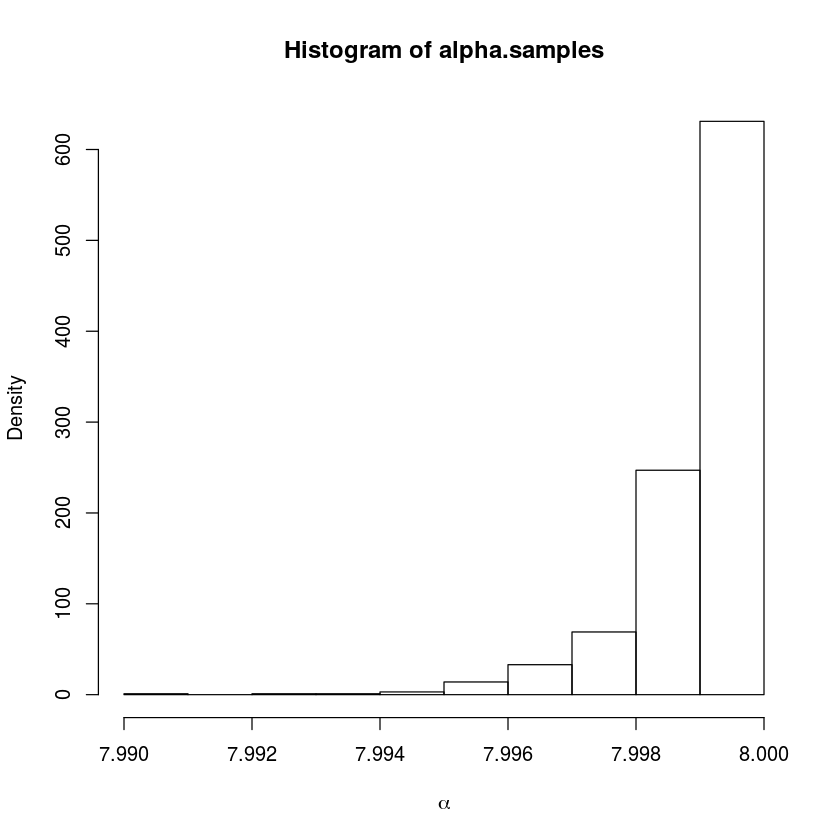

In [9]:
raw <- conpl$new(the.data) 
raw$setXmin(1)
MLE <- estimate_pars(raw)

alpha.samples <- extract(posterior.contmix, 'alpha')$alpha
hist(alpha.samples, probability = TRUE, xlab = expression(alpha))
abline(v = MLE$pars, lwd = 2, lty = 2)

In [10]:
bridgesampling::bridge_sampler(posterior.contmix)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


Bridge sampling estimate of the log marginal likelihood: -23510.24
Estimate obtained in 5 iteration(s) via method "normal".

In [11]:
raw.ln <- conlnorm$new(the.data)
raw.ln$setXmin(1)
MLE.ln <- estimate_pars(raw.ln)
forplot.ln <- raw.ln
forplot.ln$pars <- MLE.ln$pars

In [12]:
expose_stan_functions(contplaw.mix)

In [13]:
mixture_density <- function(x, alpha, xmin, mu, sigma, delta){
    dens <- pl_ln_mix_lpdf(x = x, alpha = alpha, x_min = xmin, mu = mu, sigma = sigma, delta = delta)
    return(exp(dens))
}
mixture_density <- Vectorize(mixture_density)

In [14]:
mixture_cdf <- function(x, alpha, xmin, mu, sigma, delta){
    1-integrate(function(y) mixture_density(y, alpha, xmin, mu, sigma, delta), xmin, x)$value
}
mixture_cdf <- Vectorize(mixture_cdf)

In [15]:
integrate(function(x) mixture_density(x, alpha = 8.0, xmin = 1,
                                  mu = 1.65, sigma = 1.11, delta = .5),
1, Inf)

1 with absolute error < 1.8e-05

In [16]:
trunc_lnorm <- function(x) exp( truncated_lognormal_lpdf(x, x_min = 1, mu = 1.65, sigma = 1.11) )
trunc_lnorm <- Vectorize(trunc_lnorm)                               
integrate(trunc_lnorm, 1, Inf)

1 with absolute error < 3.5e-05

In [17]:
mean_pars <- summary(posterior.contmix)$summary[, "mean"]

In [18]:
mean_pars

alpha         delta            mu         sigma          lp__ 
 7.999002e+00  5.184443e-01  5.741355e-01  1.687514e+00 -2.350426e+04

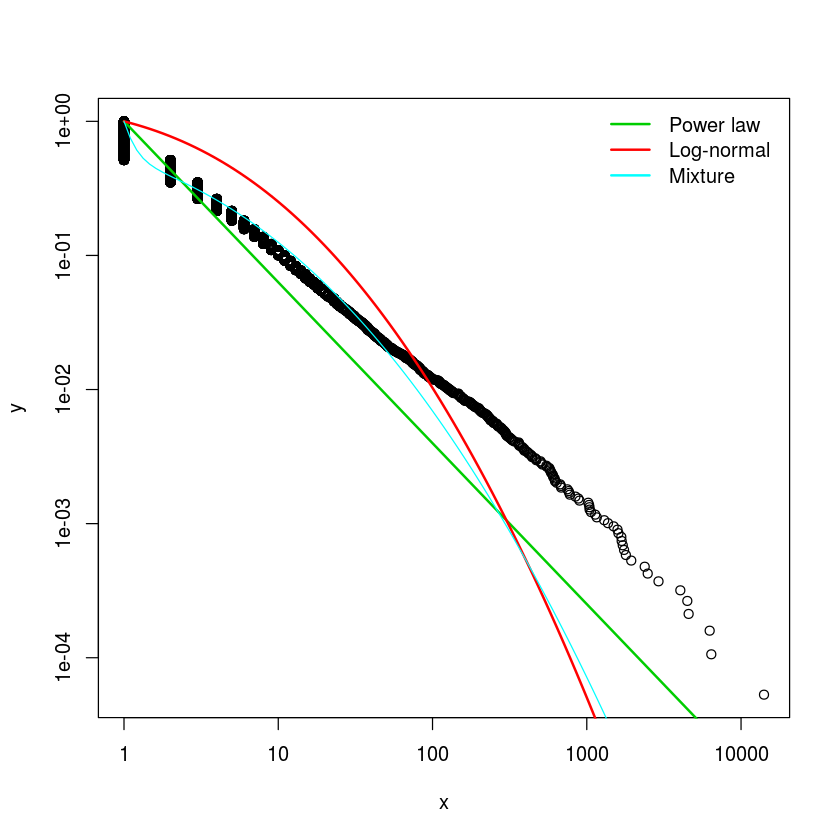

In [19]:
forplot <- raw
forplot$pars <- MLE$pars
plot(raw)
lines(forplot, col = 3, lwd = 2)
lines(forplot.ln, col = 2, lwd = 2)
curve(mixture_cdf(x,
                      alpha = mean_pars["alpha"],
                      xmin = 1,
                      mu =  mean_pars["mu"],
                      sigma = mean_pars["sigma"],
                      delta =  mean_pars["delta"]),
    1, max(pl.data$values), col = 5, add = TRUE)
legend(x = "topright",
       legend = c("Power law", "Log-normal", "Mixture"),
       col = c(3, 2, 5), lwd = 2, bty = 'n')

### Simulated data

In [20]:
rtrunclnorm <- function(n, mu, sigma, x_min){
  samples <- rep(NA, n)
  for (i in 1:n){
    x <- rlnorm(1, meanlog = mu, sdlog = sigma)
    while(x < x_min){
      x <- rlnorm(1, meanlog = mu, sdlog = sigma)
    }
    samples[i] <- x
  }
  return(samples)
}

In [21]:
rplaw_lognormal_mixture <- function(n, mu, sigma, alpha, x_min, delta){
    samples <- rep(NA, n)
  for (i in 1:n){
      u <- runif(1)
      if(u < delta){
          samples[i] <- round( rtrunclnorm(n = 1, mu = mu, sigma = sigma, x_min = x_min) )
      }else{
          samples[i] <- rpldis(n = 1, xmin = x_min, alpha = alpha)
      }
  }
    return(samples)
}

In [22]:
system.time(
    simuData <- rplaw_lognormal_mixture(n = 20000, mu = 0, sigma = 1, alpha = 2.2, x_min = 1, delta = .32)
)

   user  system elapsed 
554.732   0.132 555.174 

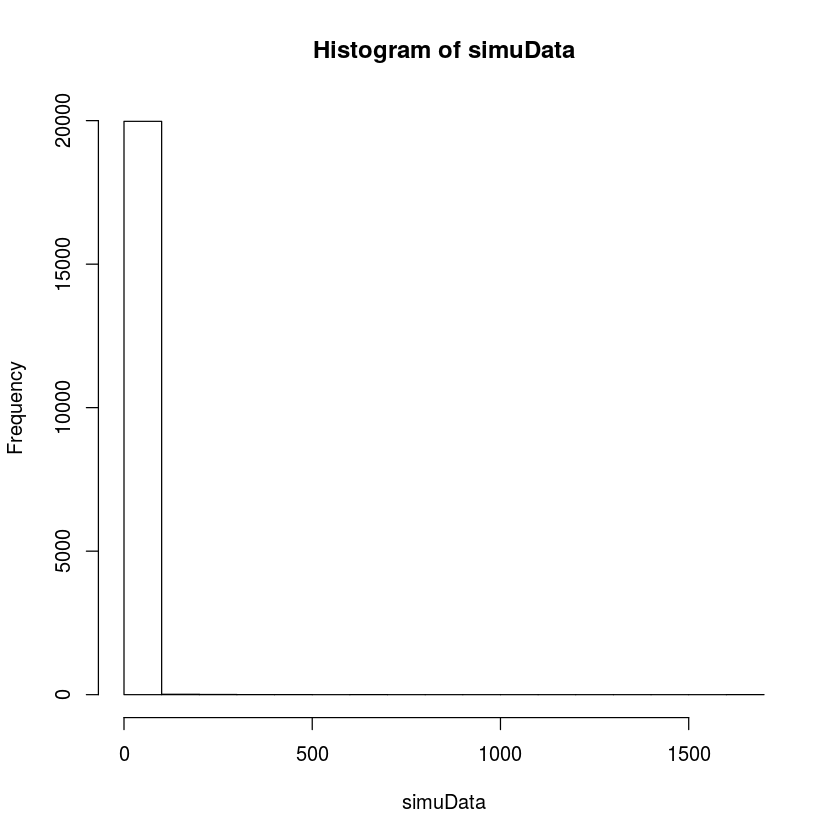

In [23]:
hist(simuData)

In [24]:
pl.data2 <- pl.data

In [25]:
cdata.simu <- compress_data(simuData)
pl.data2$K <- cdata.simu$K
pl.data2$values <- cdata.simu$v
pl.data2$frequencies <- cdata.simu$fs

In [26]:
posterior.contmix.simudata <- sampling(contplaw.mix,
                                       data = pl.data2, control = list(adapt_delta = .95), chains = 4)


SAMPLING FOR MODEL 'continuous_plaw_lognormal_mixture_fixedDelta' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.6e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.86 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.38408 seconds (Warm-up)
Chain 1:                0.72769 seconds (

Warning message:
“There were 989 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [27]:
posterior.contmix.simudata

Inference for Stan model: continuous_plaw_lognormal_mixture_fixedDelta.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean  se_mean       sd     2.5%      25%      50%    75%    97.5% n_eff
alpha   6.65     1.65     2.34     2.59     6.64     8.00   8.00     8.00     2
delta   0.37     0.07     0.10     0.20     0.36     0.43   0.43     0.44     2
mu      0.33     0.73     1.03    -1.46     0.26     0.92   0.93     0.96     2
sigma   0.68     0.26     0.37     0.04     0.65     0.89   0.90     0.92     2
lp__  990.64 13452.84 19029.95 -9998.29 -9995.26 -9994.07 982.70 33990.41     2
         Rhat
alpha 3045.22
delta   31.74
mu      60.93
sigma   34.77
lp__  2655.55

Samples were drawn using NUTS(diag_e) at Tue Mar 19 14:20:53 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).